<center><h3>Multi-class and Multi-Label Classification and Clustering</h3></center>
<center><font size=\"4\">Name: Jiahao Liu<br>Github: Julius-JiahaoLiu</font></center>

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, hamming_loss, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from joblib import Parallel, delayed
import multiprocessing

#### 1. Multi-class and Multi-Label Classification Using Support Vector Machines
(a) Download the Anuran Calls (MFCCs) Data Set. Choose 70% of the data randomly as the training set.

In [16]:
df = pd.read_csv('../data/Frogs_MFCCs.csv')

# Define feature columns (MFCCs_1 to MFCCs_22)
feature_columns = [f'MFCCs_{i}' for i in range(1, 23)]

# Define label columns
label_columns = ['Family', 'Genus', 'Species']

# Extract features and labels
X = df[feature_columns]
y = df[label_columns]

# Split the data: 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.7,      # 70% for training
    test_size=0.3,       # 30% for testing
    random_state=42,     # For reproducibility
    shuffle=True         # Shuffle before splitting
)

print(f"Total instances: {len(df)}")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Total instances: 7195
Training set size: 5036
Testing set size: 2159


(b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multilabel classification is to train a classifier for each label (binary relevance). We first try this approach:

i. Research Exact match and Hamming score/loss methods for evaluating multilabel classification and use them in evaluating the classifiers in this problem.

**Answer:**

**Exact Match (Subset Accuracy)**

Definition: Exact Match, also known as Subset Accuracy, evaluates the percentage of instances where all predicted labels exactly match the true set of labels. In other words, a prediction is considered correct only if every label for that instance is correctly predicted. 

Pros: 
- Strict Evaluation: Ensures that the model predictions are entirely accurate across all labels.
- Intuitive Interpretation: Easy to understand as it reflects complete prediction fidelity.

Cons:
- Stringent: Even if one label is incorrect, the entire prediction is marked incorrect, which might be overly harsh, especially in cases where some labels are easier to predict than others.

When to Use:
- When all labels are equally important, and you require perfect prediction across all labels.
- Suitable for scenarios where the absence of any single label error is critical.

**Hamming Loss**

Definition: Hamming Loss calculates the average fraction of labels that are incorrectly predicted. It measures the probability that a label is incorrectly predicted. Unlike Exact Match, it accounts for partial correctness of predictions.

Formula: $$ \text{Hamming Loss} = \frac{1}{N \times L} \sum_{i=1}^{N} \sum_{j=1}^{L} \text{XOR}(y_{ij}, \hat{y}_{ij}) $$ 
Where: 
- $ N $ = Number of instances
- $ L $ = Number of labels
- $ y_{ij} $ = True label
- $ \hat{y}_{ij} $ = Predicted label

Pros:
- Sensitivity to Partial Errors: Provides a more nuanced view of model performance by accounting for individual label prediction errors.
- Balanced Evaluation: Especially useful when some labels are harder to predict than others.

Cons:
- Less Intuitive: Interpretation might not be as straightforward as Exact Match.

**Hamming Score**

Definition: Hamming Score is the complement of Hamming Loss. It provides the proportion of correctly predicted labels to the total number of labels.

$$ \text{Hamming Score} = 1 - \text{Hamming Loss} $$

When to Use:
- When you want to assess how well individual labels are being predicted, regardless of whether all labels for an instance are correctly predicted.
- Suitable for imbalanced label scenarios where some labels are more frequent or significant than others.




In [ ]:
# Label Encoding: Since SVMs handle numerical labels, categorical labels (Family, Genus, Species) need to be encoded numerically. 
# LabelEncoder transforms each class label into an integer.
label_encoders = {}
for label in label_columns:
    le = LabelEncoder()
    y_train[label] = le.fit_transform(y_train[label])
    y_test[label] = le.transform(y_test[label])
    label_encoders[label] = le

# Feature Scaling: SVMs are sensitive to the scale of input features. 
# StandardScaler standardizes features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

# Initialize classifiers dictionary
classifiers = {}

# Define SVM parameters (these can be tuned further)
# Hyperparameters (C, gamma, kernel): These can significantly impact performance. 
# I will use Grid Search or Random Search for hyperparameter tuning in (b) ii because (b) i just focuses on evaluating methods.
svm_params = {
    'kernel': 'rbf',
    'C': 1.0,
    'gamma': 'scale',
    'probability': False  # Set to True if need probability estimates
}

# Train a separate SVM classifier for each label
for i, label in enumerate(label_columns):
    # decision_function_shape='ovr': Specifies the One-vs-Rest approach for multi-class classification.
    svm = SVC(**svm_params, decision_function_shape='ovr', random_state=42)
    svm.fit(X_train_standard, y_train[label]) # NumPy arrays do not retain column names.
    classifiers[label] = svm
    print(f"Trained SVM classifier for {label}")

Trained SVM classifier for Family
Trained SVM classifier for Genus
Trained SVM classifier for Species


In [24]:
# Initialize prediction DataFrame, with the same structure as y_test.
y_pred = pd.DataFrame(index = y_test.index)

# Predict each label
for i, label in enumerate(label_columns):
    classifier = classifiers[label]
    y_pred[label] = classifier.predict(X_test_standard)

# Calculate Exact Match Ratio
exact_match = np.all(y_pred.values == y_test.values, axis=1)
exact_match_ratio = np.mean(exact_match)
print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

# Initialize a list to store Hamming losses for each label
hamming_losses = []

# Calculate Hamming loss for each label
for label in label_columns:
    hl = hamming_loss(y_test[label], y_pred[label])
    hamming_losses.append(hl)
    print(f"Hamming Loss for {label}: {hl:.4f}")

# Average Hamming loss across labels (as a manual workaround for multi-output)
avg_hamming_loss = np.mean(hamming_losses)
print(f"Average Hamming Loss: {avg_hamming_loss:.4f}")

# Calculate Hamming score as 1 - Average Hamming Loss
hamming_score = 1 - avg_hamming_loss
print(f"Hamming Score: {hamming_score:.4f}")

Exact Match Ratio: 0.9805
Hamming Loss for Family: 0.0130
Hamming Loss for Genus: 0.0153
Hamming Loss for Species: 0.0153
Average Hamming Loss: 0.0145
Hamming Score: 0.9855


ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation. 

How to choose parameter ranges for SVMs? One can use wide ranges for the parameters and a fine grid (e.g. 1000 points) for cross validation; however, this method may be computationally expensive. 

An alternative way is to train the SVM with very large and very small parameters on the whole training data and find very large and very small parameters for which the training accuracy is not below a threshold (e.g., 70%). Then one can select a fixed number of parameters (e.g., 20) between those points for cross validation. 

For the penalty parameter, usually one has to consider increments in $log(\lambda)$. For example, if one found that the accuracy of a support vector machine will not be below 70% for $\lambda = 10^{-3}$ and $\lambda = 10^6$, one has to choose $\log(\lambda)\in\{-3, -2,\cdots,4,5,6\}$. 

For the Gaussian Kernel parameter, one usually chooses linear increments, e.g. $\sigma\in\{0.1, 0.2,\cdots, 1.9, 2\}$. When both $\sigma$ and $\lambda$ are to be chosen using cross-validation, combinations of very small and very large $\lambda$'s and $\sigma$'s that keep the accuracy above a threshold (e.g.70%) can be used to determine the ranges for $\sigma$ and $\lambda$. Please note that these are very rough rules of thumb, not general procedures.

You are welcome to try to solve the problem with both standardized (It seems that the data are already normalized) and raw attributes and report the results.

In [26]:
# Create a function that: Trains SVMs with extreme C and Sigma values. 
# Finds the minimum and maximum values where training accuracy remains above accuracy_threshold
def determine_parameter_ranges(X, y, accuracy_threshold=0.7):
    """
    Determines the range of C and Sigma values where training accuracy >= threshold.
    
    Parameters:
    - X: Feature matrix.
    - y: Target vector.
    - accuracy_threshold: Minimum acceptable training accuracy.
    
    Returns:
    - C_min, C_max: Minimum and maximum C values.
    - sigma_min, sigma_max: Minimum and maximum Sigma values.
    """
    # Initialize
    C_values = np.logspace(-3, 6, 10)  # From 1e-3 to 1e6
    sigma_values = np.linspace(0.1, 2.0, 20)  # From 0.1 to 2.0
    
    # Determine C_min and C_max
    C_min = None
    C_max = None
    for C in C_values:
        svm = SVC(kernel='rbf', C=C, gamma='scale', decision_function_shape='ovr', random_state=42)
        svm.fit(X, y)
        acc = accuracy_score(y, svm.predict(X))
        if acc >= accuracy_threshold:
            C_max = C
    for C in reversed(C_values):
        svm = SVC(kernel='rbf', C=C, gamma='scale', decision_function_shape='ovr', random_state=42)
        svm.fit(X, y)
        acc = accuracy_score(y, svm.predict(X))
        if acc >= accuracy_threshold:
            C_min = C
    if C_min is None:
        C_min = C_values[0]
    if C_max is None:
        C_max = C_values[-1]
    
    # Determine sigma_min and sigma_max
    sigma_min = None
    sigma_max = None
    for sigma in sigma_values:
        gamma = 1 / (2 * sigma**2)
        svm = SVC(kernel='rbf', C=1.0, gamma=gamma, decision_function_shape='ovr', random_state=42)
        svm.fit(X, y)
        acc = accuracy_score(y, svm.predict(X))
        if acc >= accuracy_threshold:
            sigma_max = sigma
    for sigma in reversed(sigma_values):
        gamma = 1 / (2 * sigma**2)
        svm = SVC(kernel='rbf', C=1.0, gamma=gamma, decision_function_shape='ovr', random_state=42)
        svm.fit(X, y)
        acc = accuracy_score(y, svm.predict(X))
        if acc >= accuracy_threshold:
            sigma_min = sigma
    if sigma_min is None:
        sigma_min = sigma_values[0]
    if sigma_max is None:
        sigma_max = sigma_values[-1]
    
    return C_min, C_max, sigma_min, sigma_max

# Based on the determined ranges to create a logarithmic grid for C and a linear grid for Sigma.
def create_parameter_grid(C_min, C_max, sigma_min, sigma_max, num_C=7, num_sigma=20):
    """
    Creates a parameter grid for GridSearchCV.
    
    Parameters:
    - C_min, C_max: Range for penalty parameter C (log scale).
    - sigma_min, sigma_max: Range for sigma (linear scale).
    - num_C: Number of C values.
    - num_sigma: Number of sigma values.
    
    Returns:
    - param_grid: Dictionary with 'C' and 'gamma' for GridSearchCV.
    """
    C_values = np.logspace(np.log10(C_min), np.log10(C_max), num=num_C)
    sigma_values = np.linspace(sigma_min, sigma_max, num=num_sigma)
    gamma_values = 1 / (2 * sigma_values**2)
    
    param_grid = {
        'C': C_values,
        'gamma': gamma_values
    }
    
    return param_grid

# Set up a GridSearchCV object with the parameter grid to perform 10-fold cross-validation to find the best C and γ.
def perform_grid_search(X, y, param_grid):
    """
    Performs GridSearchCV to find the best C and gamma.
    
    Parameters:
    - X: Feature matrix.
    - y: Target vector.
    - param_grid: Dictionary with 'C' and 'gamma'.
    
    Returns:
    - best_estimator: Trained SVM model with best parameters.
    - best_params: Best parameters found.
    - best_score: Best cross-validation score.
    """
    svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=42)
    # 10-fold cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X, y)
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return best_estimator, best_params, best_score

The following is to iterate over each label (Family, Genus, Species) and perform the following for both standardized and raw datasets:
- Determine suitable C and Sigma ranges.
- Create a parameter grid.
- Perform grid search with cross-validation to find the best parameters.
- Store the best models and their parameters.

In [27]:
# Initialize dictionaries to store best models and parameters
best_models = {
    'standardized': {label: None for label in label_columns},
    'raw': {label: None for label in label_columns}
}

best_params = {
    'standardized': {label: {} for label in label_columns},
    'raw': {label: {} for label in label_columns}
}

best_scores = {
    'standardized': {label: 0.0 for label in label_columns},
    'raw': {label: 0.0 for label in label_columns}
}

# Define datasets
datasets = {
    'standardized': X_train_standard,
    'raw': X_train.values  # Convert to NumPy array
}

for dataset_name, X_current in datasets.items():
    print(f"\n===== Processing {dataset_name} dataset =====")
    for label in label_columns:
        print(f"\n--- Tuning hyperparameters for label: {label} ---")
        y_current = y_train[label].values
        
        # Step 1: Determine parameter ranges
        C_min, C_max, sigma_min, sigma_max = determine_parameter_ranges(X_current, y_current, accuracy_threshold=0.7)
        print(f"Determined ranges -> C: [{C_min:.1e}, {C_max:.1e}], Simga: [{sigma_min:.2f}, {sigma_max:.2f}]")
        
        # Step 2: Create parameter grid
        param_grid = create_parameter_grid(C_min, C_max, sigma_min, sigma_max, num_C=7, num_sigma=20)
        print(f"Parameter grid created with {len(param_grid['C'])} C values and {len(param_grid['gamma'])} Gamma values.")
        
        # Step 3: Perform grid search
        best_estimator, best_param, best_score = perform_grid_search(X_current, y_current, param_grid)
        print(f"Best Parameters: C = {best_param['C']}, Gamma = {best_param['gamma']:.4f}")
        print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
        
        # Step 4: Store the best model and parameters
        best_models[dataset_name][label] = best_estimator
        best_params[dataset_name][label] = best_param
        best_scores[dataset_name][label] = best_score



===== Processing standardized dataset =====

--- Tuning hyperparameters for label: Family ---
Determined ranges -> C: [1.0e-02, 1.0e+06], Simga: [0.10, 2.00]
Parameter grid created with 7 C values and 20 Gamma values.
Best Parameters: C = 4.6415888336127775, Gamma = 0.1250
Best Cross-Validation Accuracy: 0.9891

--- Tuning hyperparameters for label: Genus ---
Determined ranges -> C: [1.0e-02, 1.0e+06], Simga: [0.10, 2.00]
Parameter grid created with 7 C values and 20 Gamma values.
Best Parameters: C = 100.0, Gamma = 0.1250
Best Cross-Validation Accuracy: 0.9857

--- Tuning hyperparameters for label: Species ---
Determined ranges -> C: [1.0e-02, 1.0e+06], Simga: [0.10, 2.00]
Parameter grid created with 7 C values and 20 Gamma values.
Best Parameters: C = 4.6415888336127775, Gamma = 0.1250
Best Cross-Validation Accuracy: 0.9823

===== Processing raw dataset =====

--- Tuning hyperparameters for label: Family ---
Determined ranges -> C: [1.0e-02, 1.0e+06], Simga: [0.10, 2.00]
Parameter g

In [39]:
# After training the models with the best parameters, I will evaluate their performance on the test set for both standardized and raw datasets.
def evaluate_models(models_dict, dataset_type, X_test, y_test, label_columns):
    """
    Evaluates the models on the test set and calculates Exact Match Ratio and Hamming Loss.
    
    Parameters:
    - models_dict: Dictionary containing trained models.
    - dataset_type: 'standardized' or 'raw'.
    - X_test: Test feature matrix.
    - y_test: Encoded test labels.
    - label_columns: List of label names.
    
    Returns:
    - exact_match_ratio: Exact Match Ratio for the dataset.
    - hamming_losses: Dictionary of Hamming Loss for each label.
    """
    y_pred = pd.DataFrame(index=y_test.index, columns=label_columns)
    
    for label in label_columns:
        model = models_dict[label]
        X_to_predict = X_test 
        y_pred[label] = model.predict(X_to_predict)
        print(f"Predicted {label} for {dataset_type} dataset.")
    
    # Calculate Exact Match Ratio
    exact_match = np.all(y_pred.values == y_test[label_columns].values, axis=1)
    exact_match_ratio = np.mean(exact_match)
    print(f"Exact Match Ratio for {dataset_type} dataset: {exact_match_ratio:.4f}")
    
    # Calculate Hamming Loss for each label
    hamming_losses = {}
    for label in label_columns:
        hl = hamming_loss(y_test[label], y_pred[label])
        hamming_losses[label] = hl
        print(f"Hamming Loss for {label} on {dataset_type} dataset: {hl:.4f}")
    
    return exact_match_ratio, hamming_losses

In [30]:
# Initialize dictionaries to store evaluation metrics
evaluation_results = {
    'standardized': {'ExactMatchRatio': 0.0, 'HammingLoss': {}},
    'raw': {'ExactMatchRatio': 0.0, 'HammingLoss': {}}
}

# Evaluate for standardized dataset
print("\n===== Evaluating Standardized Dataset =====")
exact_ratio_std, hamming_std = evaluate_models(
    best_models['standardized'],
    'standardized',
    X_test_standard,
    y_test,
    label_columns
)
evaluation_results['standardized']['ExactMatchRatio'] = exact_ratio_std
evaluation_results['standardized']['HammingLoss'] = hamming_std

# Evaluate for raw dataset
print("\n===== Evaluating Raw Dataset =====")
exact_ratio_raw, hamming_raw = evaluate_models(
    best_models['raw'],
    'raw',
    X_test.values,
    y_test,
    label_columns
)
evaluation_results['raw']['ExactMatchRatio'] = exact_ratio_raw
evaluation_results['raw']['HammingLoss'] = hamming_raw



===== Evaluating Standardized Dataset =====
Predicted Family for standardized dataset.
Predicted Genus for standardized dataset.
Predicted Species for standardized dataset.
Exact Match Ratio for standardized dataset: 0.9815
Hamming Loss for Family on standardized dataset: 0.0097
Hamming Loss for Genus on standardized dataset: 0.0134
Hamming Loss for Species on standardized dataset: 0.0181

===== Evaluating Raw Dataset =====
Predicted Family for raw dataset.
Predicted Genus for raw dataset.
Predicted Species for raw dataset.
Exact Match Ratio for raw dataset: 0.9893
Hamming Loss for Family on raw dataset: 0.0051
Hamming Loss for Genus on raw dataset: 0.0088
Hamming Loss for Species on raw dataset: 0.0102



===== Exact Match Ratios =====
        Dataset  Exact Match Ratio
0  Standardized           0.981473
1           Raw           0.989347

===== Hamming Losses =====
     Label  Standardized       Raw
0   Family      0.009727  0.005095
1    Genus      0.013432  0.008800
2  Species      0.018064  0.010190


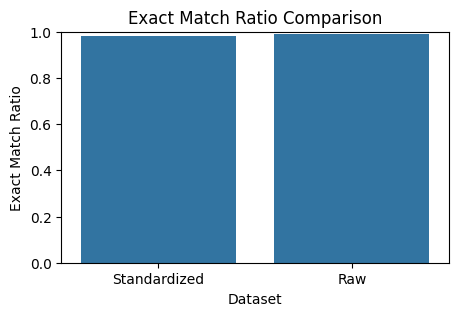

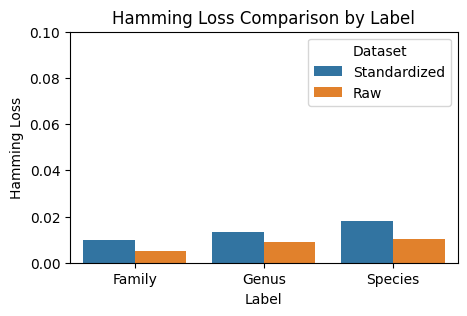

In [34]:
# Create a DataFrame for Exact Match Ratio
exact_match_df = pd.DataFrame({
    'Dataset': ['Standardized', 'Raw'],
    'Exact Match Ratio': [evaluation_results['standardized']['ExactMatchRatio'],
                          evaluation_results['raw']['ExactMatchRatio']]
})

# Create a DataFrame for Hamming Loss
hamming_df = pd.DataFrame({
    'Label': label_columns,
    'Standardized': [evaluation_results['standardized']['HammingLoss'][label] for label in label_columns],
    'Raw': [evaluation_results['raw']['HammingLoss'][label] for label in label_columns]
})

# Display Exact Match Ratios
print("\n===== Exact Match Ratios =====")
print(exact_match_df)

# Display Hamming Losses
print("\n===== Hamming Losses =====")
print(hamming_df)

# Plot Exact Match Ratio
plt.figure(figsize=(5,3))
sns.barplot(x='Dataset', y='Exact Match Ratio', data=exact_match_df)
plt.title('Exact Match Ratio Comparison')
plt.ylim(0,1)
plt.show()

# Plot Hamming Loss
hamming_melted = hamming_df.melt(id_vars='Label', var_name='Dataset', value_name='Hamming Loss')
plt.figure(figsize=(5,3))
sns.barplot(x='Label', y='Hamming Loss', hue='Dataset', data=hamming_melted)
plt.title('Hamming Loss Comparison by Label')
plt.ylim(0,0.1)
plt.show()


**Conclusion:**
- Standardized vs. Raw Normalized Data: From the results of Exact Match Ratios and Hamming Losses, we can see Raw Normalized Data leads to a better performance, which is kind of abnormal. I think the variance of raw data might contributes to a better classifier for each label, thus a better Exact Match Ratio with cross all three labels.
- Parameter Sensitivity: The choice of C and γ (related to σ) significantly impacts the model's performance. The best Gamma for three different labels SVM Classifier are all 0.1250, while the best C varies from 4.64 to 100.
- Label-wise Performance: Different labels might exhibit varying levels of difficulty in classification. Analyze Hamming Losses tell us the classifications of "Species" are more challenging.

iii. Repeat 1(b)ii with L1-penalized SVMs (The convention is to use L1 penalty with linear kernel).

Remember to standardize (It seems that the data are already normalized) the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [49]:
def tune_hyperparameters(X, y, cv_folds=10):
    """
    Performs hyperparameter tuning for LinearSVC with L1 penalty using GridSearchCV.
    
    Parameters:
    - X: Feature matrix.
    - y: Target vector.
    - cv_folds: Number of cross-validation folds.
    
    Returns:
    - best_estimator: Model with the best found parameters.
    - best_params: Best parameters found.
    - best_score: Best cross-validation score.
    """
    # Initialize LinearSVC with L1 penalty
    lsvc = LinearSVC(penalty='l1', dual=False, loss='squared_hinge', max_iter=20000, random_state=42)
    
    # Define parameter grid
    param_grid = {
        'C': np.logspace(-3, 6, 10)
    }
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=lsvc,
        param_grid=param_grid,
        cv=KFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    # Perform grid search
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

In [50]:
# Initialize dictionaries to store best models and parameters
best_models_l1_penalty = {label: None for label in label_columns}
best_params_l1_penalty = {label: {} for label in label_columns}
best_scores_l1_penalty = {label: 0.0 for label in label_columns}

for label in label_columns:
    print(f"\n--- Tuning hyperparameters for label: {label} ---")
    y_current = y_train[label].values
    
    # Perform hyperparameter tuning
    best_estimator, best_param, best_score = tune_hyperparameters(X_train_standard, y_current, cv_folds=10)
    
    print(f"Best Parameters for {label}: C = {best_param['C']}")
    print(f"Best Cross-Validation Accuracy for {label}: {best_score:.4f}")
    
    # Store the best model and its parameters
    best_models_l1_penalty[label] = best_estimator
    best_params_l1_penalty[label] = best_param
    best_scores_l1_penalty[label] = best_score



--- Tuning hyperparameters for label: Family ---
Best Parameters for Family: C = 100.0
Best Cross-Validation Accuracy for Family: 0.9396

--- Tuning hyperparameters for label: Genus ---
Best Parameters for Genus: C = 10.0
Best Cross-Validation Accuracy for Genus: 0.9525

--- Tuning hyperparameters for label: Species ---
Best Parameters for Species: C = 10.0
Best Cross-Validation Accuracy for Species: 0.9597


In [54]:
# Evaluate the models
exact_match_ratio, hamming_losses = evaluate_models(
    best_models_l1_penalty,
    'standardized',
    X_test_standard,
    y_test,
    label_columns
)

# Create a DataFrame for Exact Match Ratio
exact_match_df = pd.DataFrame({
    'Label': label_columns,
    'Cross-Validation Accuracy': [best_scores_l1_penalty[label] for label in label_columns]
})

print("\n===== Cross-Validation Accuracies =====")
print(exact_match_df)

# Create a DataFrame for Hamming Loss
hamming_df = pd.DataFrame({
    'Label': label_columns,
    'Hamming Loss': [hamming_losses[label] for label in label_columns]
})

print("\n===== Hamming Losses =====")
print(hamming_df)

print(f"\n===== Overall Exact Match Ratio =====")
print(f"{exact_match_ratio:.4f}")


Predicted Family for standardized dataset.
Predicted Genus for standardized dataset.
Predicted Species for standardized dataset.
Exact Match Ratio for standardized dataset: 0.9125
Hamming Loss for Family on standardized dataset: 0.0718
Hamming Loss for Genus on standardized dataset: 0.0584
Hamming Loss for Species on standardized dataset: 0.0408

===== Cross-Validation Accuracies =====
     Label  Cross-Validation Accuracy
0   Family                   0.939636
1    Genus                   0.952545
2  Species                   0.959693

===== Hamming Losses =====
     Label  Hamming Loss
0   Family      0.071792
1    Genus      0.058360
2  Species      0.040760

===== Overall Exact Match Ratio =====
0.9125


iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

**Answer:** SMOTE (Synthetic Minority Oversampling Technique) is widely used for single-label classification tasks to balance classes by synthetically generating new instances for minority classes. However, applying SMOTE directly to multi-label data presents challenges because:

- Label Correlation: Generating synthetic instances independently for each label can disrupt the inherent correlations between labels.
- Computational Complexity: Applying SMOTE separately for each label can be computationally intensive.

Here, I would use **Class Weights in Classifiers** by adjusting the cost function to penalize misclassification of minority classes more heavily. This is the most straightforward and effective method for addressing class imbalance in *LinearSVC*, because I already have Normalized data and have trained individual classifiers for each label.

In [ ]:
def tune_hyperparameters_weighted(X, y, cv_folds=10):
    """
    Performs hyperparameter tuning for LinearSVC with L1 penalty and class weights using GridSearchCV.
    
    Parameters:
    - X: Feature matrix.
    - y: Target vector.
    - cv_folds: Number of cross-validation folds.
    
    Returns:
    - best_estimator: Model with the best found parameters.
    - best_params: Best parameters found.
    - best_score: Best cross-validation score.
    """
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))

    # Initialize LinearSVC with L1 penalty and class_weight='balanced'
    lsvc = LinearSVC(penalty='l1', dual=False, loss='squared_hinge', max_iter=20000, class_weight=class_weight_dict, random_state=42)
    
    # Define parameter grid
    param_grid = {
        'C': np.logspace(-3, 6, 10)
    }
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=lsvc,
        param_grid=param_grid,
        cv=KFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    # Perform grid search
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def retrain_classifiers_with_class_weights(X_train, y_train, label_columns):
    """
    Retrains LinearSVC classifiers with class weights for each label.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Encoded training labels.
    - label_columns: List of label names.
    
    Returns:
    - best_models_weighted: Dictionary of retrained classifiers with class weights.
    - best_params_weighted: Dictionary of best parameters for each classifier.
    - best_scores_weighted: Dictionary of best cross-validation scores.
    """
    best_models_weighted = {}
    best_params_weighted = {}
    best_scores_weighted = {}
    
    for label in label_columns:
        print(f"\n--- Tuning hyperparameters with class weights for label: {label} ---")
        y_current = y_train[label].values
        
        # Perform hyperparameter tuning with class weights
        best_estimator, best_param, best_score = tune_hyperparameters_weighted(X_train, y_current, cv_folds=10)
        
        print(f"Best Parameters for {label}: C = {best_param['C']}")
        print(f"Best Cross-Validation Accuracy for {label}: {best_score:.4f}")
        
        # Store the best model and its parameters
        best_models_weighted[label] = best_estimator
        best_params_weighted[label] = best_param
        best_scores_weighted[label] = best_score
    
    return best_models_weighted, best_params_weighted, best_scores_weighted

# Retrain classifiers with class weights
best_models_weighted, best_params_weighted, best_scores_weighted = retrain_classifiers_with_class_weights(
    X_train_standard,
    y_train,
    label_columns
)


--- Tuning hyperparameters with class weights for label: Family ---
Best Parameters for Family: C = 10.0
Best Cross-Validation Accuracy for Family: 0.9337

--- Tuning hyperparameters with class weights for label: Genus ---
Best Parameters for Genus: C = 10.0
Best Cross-Validation Accuracy for Genus: 0.9442

--- Tuning hyperparameters with class weights for label: Species ---
Best Parameters for Species: C = 1000.0
Best Cross-Validation Accuracy for Species: 0.9587


In [63]:
# Evaluate the new models (with class weights)
exact_match_ratio_weighted, hamming_losses_weighted = evaluate_models(
    best_models_weighted,
    'standardized and class-weighted',
    X_test_standard,
    y_test,
    label_columns
)

Predicted Family for standardized and class-weighted dataset.
Predicted Genus for standardized and class-weighted dataset.
Predicted Species for standardized and class-weighted dataset.
Exact Match Ratio for standardized and class-weighted dataset: 0.9069
Hamming Loss for Family on standardized and class-weighted dataset: 0.0783
Hamming Loss for Genus on standardized and class-weighted dataset: 0.0593
Hamming Loss for Species on standardized and class-weighted dataset: 0.0403


In [64]:
# Compile Cross-Validation Accuracies
cv_accuracies_df = pd.DataFrame({
    'Label': label_columns,
    'Original CV Accuracy': [best_scores_l1_penalty[label] for label in label_columns],
    'Weighted CV Accuracy': [best_scores_weighted[label] for label in label_columns]
})

print("\n===== Cross-Validation Accuracies Comparison =====")
print(cv_accuracies_df)

# Compile Hamming Losses
hamming_comparison_df = pd.DataFrame({
    'Label': label_columns,
    'Original Hamming Loss': [hamming_losses[label] for label in label_columns],
    'Weighted Hamming Loss': [hamming_losses_weighted[label] for label in label_columns]
})

print("\n===== Hamming Losses Comparison =====")
print(hamming_comparison_df)

# Overall Exact Match Ratio
exact_match_comparison_df = pd.DataFrame({
    'Metric': ['Exact Match Ratio'],
    'Original': [exact_match_ratio],
    'Weighted': [exact_match_ratio_weighted]
})

print("\n===== Overall Exact Match Ratio Comparison =====")
print(exact_match_comparison_df)


===== Cross-Validation Accuracies Comparison =====
     Label  Original CV Accuracy  Weighted CV Accuracy
0   Family              0.939636              0.933680
1    Genus              0.952545              0.944204
2  Species              0.959693              0.958700

===== Hamming Losses Comparison =====
     Label  Original Hamming Loss  Weighted Hamming Loss
0   Family               0.071792               0.078277
1    Genus               0.058360               0.059287
2  Species               0.040760               0.040296

===== Overall Exact Match Ratio Comparison =====
              Metric  Original  Weighted
0  Exact Match Ratio  0.912459  0.906901


**Conclusion:** we can see from above Comparison of Cross-Validation Accuracies and Hamming Losses that the Classifers after remedy for class imbalance shows no significant positive even negative influence on the performance. This might be explained by the fact that **we have randomly split the train and test dataset** leads to similar imbalance in test set with train set. In this scenario, the L1 penality and linear kernel SVM can have better performance.

v. Extra Practice: Study the Classifier Chain method and apply it to the above problem.

In [80]:
def tune_hyperparameters_classifier_chain(X, y, cv_folds=10):
    """
    Tune hyperparameters for a Classifier Chain with L1-penalized LinearSVC.

    Parameters:
    - X: Feature matrix.
    - y: Multi-label target matrix (binary indicators for each label).
    - cv_folds: Number of cross-validation folds.

    Returns:
    - best_chain: Best ClassifierChain estimator after grid search.
    - best_params: Best hyperparameters found.
    - best_score: Best cross-validation score achieved.
    """
    # Initialize the base LinearSVC with L1 penalty
    base_svc = LinearSVC(
        penalty='l1',
        dual=False,
        loss='squared_hinge',
        max_iter=30000,
        tol=1e-3,
        random_state=42
    )
    
    # Create the ClassifierChain with the base estimator
    chain = ClassifierChain(
        base_estimator=base_svc,
        random_state=42
    )
    
    # Define the parameter grid for the base estimator within the chain
    param_grid = {
        'base_estimator__C': np.logspace(-3, 6, 10)
    }
    
    # Set up GridSearchCV with the ClassifierChain
    grid_search = GridSearchCV(
        estimator=chain,
        param_grid=param_grid,
        cv=KFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='accuracy',  # You might consider a different metric for multi-label
        n_jobs=-1,
        verbose=1  # Set to 1 for progress logs
    )
    
    # Fit the grid search to the data
    grid_search.fit(X, y)
    
    # Return the best estimator, parameters, and score
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

In [81]:
# One-Hot Encode Each Label Column Separately
# This converts each multi-class label into binary columns
y_family = pd.get_dummies(df['Family'], prefix='Family')
y_genus = pd.get_dummies(df['Genus'], prefix='Genus')
y_species = pd.get_dummies(df['Species'], prefix='Species')

# Step 3: Concatenate All Binarized Labels to Form a Multi-Label Matrix
y_chain = np.hstack([y_family.values, y_genus.values, y_species.values])

# Step 4: Split into Training and Testing Sets
X_train_chain, X_test_chain, y_train_chain, y_test_chain = train_test_split(
    X, y_chain, train_size=0.7, random_state=42, shuffle=True
)

# Step 5: Standardize Features
scaler = StandardScaler()
X_train_chain = scaler.fit_transform(X_train_chain)
X_test_chain = scaler.transform(X_test_chain)

# Tune hyperparameters using the Classifier Chain method
best_chain, best_params_l1_penalty_chain, best_scores_l1_penalty_chain = tune_hyperparameters_classifier_chain(X_train_chain, y_train_chain, cv_folds=10)

print("\n===== Best Parameters for Classifier Chain with L1 Penalty =====")
print(best_params_l1_penalty_chain)
print(f"Best Cross-Validation Accuracy: {best_scores_l1_penalty_chain:.4f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits

===== Best Parameters for Classifier Chain with L1 Penalty =====
{'base_estimator__C': 1.0}
Best Cross-Validation Accuracy: 0.9283


In [82]:
print("y_family shape:", y_family.shape)
print("y_genus shape:", y_genus.shape)
print("y_species shape:", y_species.shape)
print("y_chain shape:", y_chain.shape)

y_family shape: (7195, 4)
y_genus shape: (7195, 8)
y_species shape: (7195, 10)
y_chain shape: (7195, 22)


In [105]:
def evaluate_classifier_chain(model, X_test, y_test_chain, label_types):
    """
    Evaluates the Classifier Chain model on the test set and calculates:
    - Exact Match Ratio
    - Hamming Loss (overall and per label type)

    Parameters:
    - model: Trained ClassifierChain model.
    - X_test: Test feature matrix.
    - y_test_chain: Encoded test labels as a numpy array.
    - label_types: Dictionary specifying which column indices belong to each label type.

    Returns:
    - exact_match_ratio: Exact Match Ratio for the dataset.
    - hamming_loss_overall: Overall Hamming Loss.
    - hamming_loss_per_type: Hamming Loss per label type.
    """
    # Predict using the classifier chain
    # With the Classifier Chain method, a single model predicts all labels jointly, leveraging label dependencies.
    y_pred_chain = model.predict(X_test)

    # Exact Match Ratio
    exact_match = np.all(y_pred_chain == y_test_chain, axis=1)
    exact_match_ratio = np.mean(exact_match)
    print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

    # Overall Hamming Loss
    hamming_loss_overall = hamming_loss(y_test_chain, y_pred_chain)
    print(f"Overall Hamming Loss: {hamming_loss_overall:.4f}")

    # Hamming Loss per Label Type
    hamming_loss_per_type = {}
    for label_type, indices in label_types.items():
        y_test_subset = y_test_chain[:, indices]
        y_pred_subset = y_pred_chain[:, indices]
        hl = hamming_loss(y_test_subset, y_pred_subset)
        hamming_loss_per_type[label_type] = hl
        print(f"Hamming Loss for {label_type}: {hl:.4f}")

    return exact_match_ratio, hamming_loss_overall, hamming_loss_per_type


# Adjust the indices based on how y_chain was constructed
label_types = {
    'Family': list(range(y_family.shape[1])),
    'Genus': list(range(y_family.shape[1], y_family.shape[1] + y_genus.shape[1])),
    'Species': list(range(y_family.shape[1] + y_genus.shape[1], y_chain.shape[1]))
}

# Call the evaluation function
exact_match_ratio, overall_hamming_loss, per_type_hamming_loss = evaluate_classifier_chain(
    model=best_chain,
    X_test=X_test_chain,
    y_test_chain=y_test_chain,
    label_types=label_types
)

Exact Match Ratio: 0.9250
Overall Hamming Loss: 0.0195
Hamming Loss for Family: 0.0330
Hamming Loss for Genus: 0.0185
Hamming Loss for Species: 0.0149


vi. Extra Practice: Research how confusion matrices, precision, recall, ROC, and AUC are defined for multi-label classification and compute them for the classifiers you trained in above.

**Answers:**

**Confusion Matrix** 

For multi-label classification is typically computed per label rather than globally.

**Precision and Recall** 

Precision (Per Label): The ratio of correctly predicted positive observations to the total predicted positives.
$$ \text{Precision} = \frac{TP}{TP + FP} $$

Recall (Per Label): The ratio of correctly predicted positive observations to all actual positives.
$$ \text{Recall} = \frac{TP}{TP + FN} $$

Averaging Methods:
- Macro-Average: Calculate metrics independently for each label and then take the average. Treats all labels equally.
- Micro-Average: Aggregate the contributions of all labels to compute the average metric. Useful when you have imbalanced label distributions.
- Weighted-Average: Calculate metrics for each label and compute their average weighted by the number of true instances for each label.

**ROC and AUC**

ROC Curve (Receiver Operating Characteristic): Plots the True Positive Rate (Recall) against the False Positive Rate $FP / (FP + TN)$ at various threshold settings.

AUC (Area Under the Curve): Measures the entire two-dimensional area underneath the ROC curve, providing an aggregate measure of performance across all classification thresholds.

Multi-Label Context:
- Compute ROC and AUC per label.
- Aggregate AUC scores using micro, macro, or weighted averaging.


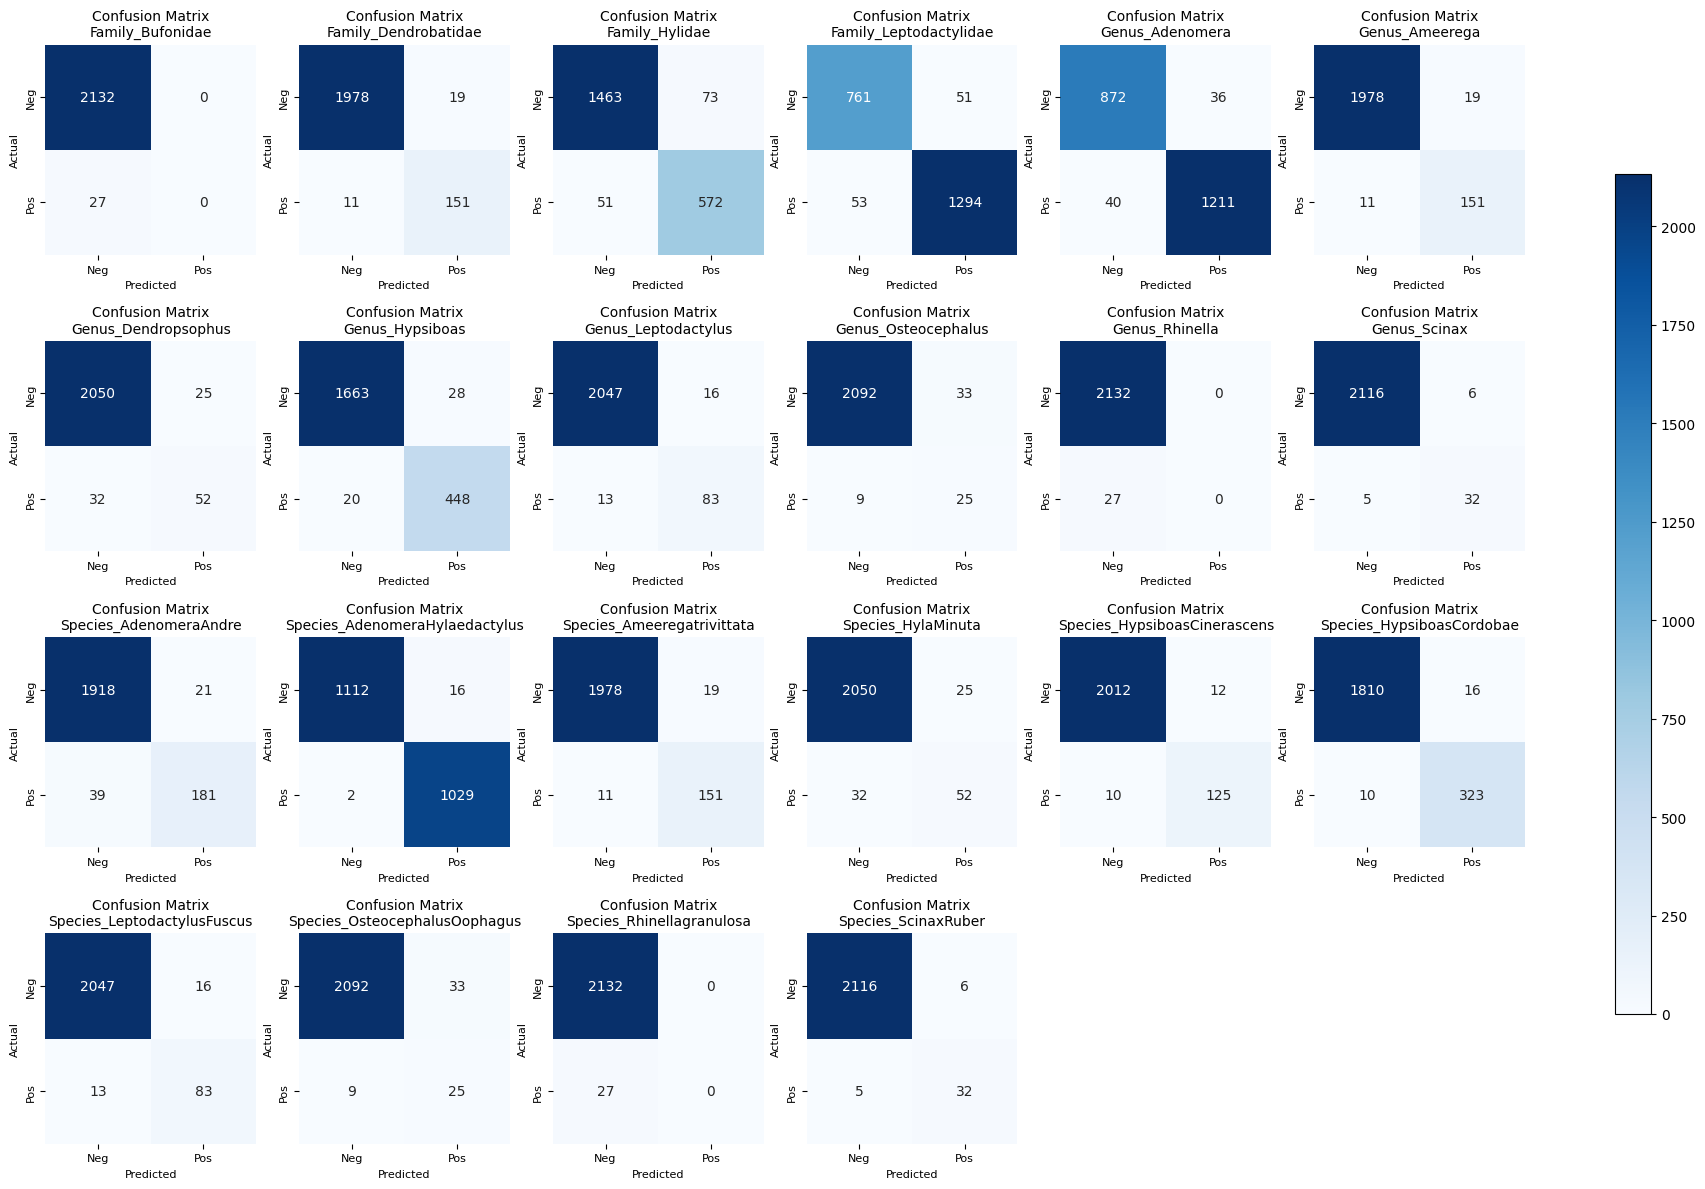

In [123]:
# Predict binary labels
y_pred_chain = best_chain.predict(X_test_chain)
y_scores = best_chain.decision_function(X_test_chain)

def compute_confusion_matrices(y_true, y_pred, label_names):
    confusion_matrices = {}
    for idx, label in enumerate(label_names):
        cm = confusion_matrix(y_true[:, idx], y_pred[:, idx])
        confusion_matrices[label] = cm
    return confusion_matrices

# Example usage:
confusion_matrices = compute_confusion_matrices(y_test_chain, y_pred_chain, label_columns)

def plot_combined_confusion_matrices(confusion_matrices, label_names, n_cols=6, figsize_per_plot=(3, 3)):
    """
    Plots multiple confusion matrices in a combined grid layout.

    Parameters:
    - confusion_matrices: Dictionary of confusion matrices with label names as keys.
    - label_names: List of label names corresponding to the confusion matrices.
    - n_cols: Number of columns in the grid.
    - figsize_per_plot: Tuple specifying the size of each subplot.
    """
    n_labels = len(label_names)
    n_rows = int(np.ceil(n_labels / n_cols))

    # Find the maximum value in all confusion matrices to set a common color scale
    max_val = max(cm.max() for cm in confusion_matrices.values())
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = axes.flatten()  # Flatten in case of multiple rows
    
    for idx, label in enumerate(label_names):
        cm = confusion_matrices[label]
        df_cm = pd.DataFrame(cm, index=['Neg', 'Pos'],
                             columns=['Neg', 'Pos'])
        
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix\n{label}', fontsize=10)
        axes[idx].set_xlabel('Predicted', fontsize=8)
        axes[idx].set_ylabel('Actual', fontsize=8)
        
        # Adjust tick label size for readability
        axes[idx].tick_params(labelsize=8)
    
    # Turn off any unused subplots
    total_subplots = n_rows * n_cols
    if n_labels < total_subplots:
        for idx in range(n_labels, total_subplots):
            axes[idx].axis('off')
    
     # Adjust layout to accommodate the colorbar
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max_val))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)
    
    plt.show()

# Plot all confusion matrices in a combined grid
plot_combined_confusion_matrices(confusion_matrices, label_columns, n_cols=6, figsize_per_plot=(3, 3))


In [124]:
# Per label precision and recall
precision_per_label = precision_score(y_test_chain, y_pred_chain, average=None, zero_division=0)
recall_per_label = recall_score(y_test_chain, y_pred_chain, average=None, zero_division=0)

# Assuming y_family, y_genus, y_species are your one-hot encoded labels
label_columns = list(y_family.columns) + list(y_genus.columns) + list(y_species.columns)
# Create a DataFrame mapping labels to their precision and recall
metrics_df = pd.DataFrame({
    'Label': label_columns,
    'Precision': precision_per_label,
    'Recall': recall_per_label
})

print("\n===== Per-Label Precision and Recall =====")
print(metrics_df)

# Aggregated metrics
precision_micro = precision_score(y_test_chain, y_pred_chain, average='micro')
precision_macro = precision_score(y_test_chain, y_pred_chain, average='macro', zero_division=0)
recall_micro = recall_score(y_test_chain, y_pred_chain, average='micro')
recall_macro = recall_score(y_test_chain, y_pred_chain, average='macro', zero_division=0)

print(f"\nPrecision (Micro): {precision_micro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")


===== Per-Label Precision and Recall =====
                             Label  Precision    Recall
0                 Family_Bufonidae   0.000000  0.000000
1             Family_Dendrobatidae   0.888235  0.932099
2                   Family_Hylidae   0.886822  0.918138
3           Family_Leptodactylidae   0.962082  0.960653
4                  Genus_Adenomera   0.971131  0.968026
5                   Genus_Ameerega   0.888235  0.932099
6              Genus_Dendropsophus   0.675325  0.619048
7                  Genus_Hypsiboas   0.941176  0.957265
8              Genus_Leptodactylus   0.838384  0.864583
9              Genus_Osteocephalus   0.431034  0.735294
10                  Genus_Rhinella   0.000000  0.000000
11                    Genus_Scinax   0.842105  0.864865
12          Species_AdenomeraAndre   0.896040  0.822727
13  Species_AdenomeraHylaedactylus   0.984689  0.998060
14      Species_Ameeregatrivittata   0.888235  0.932099
15              Species_HylaMinuta   0.675325  0.619048
16  

AUC per label:
                             Label       AUC
0                 Family_Bufonidae  0.987232
1             Family_Dendrobatidae  0.991830
2                   Family_Hylidae  0.971766
3           Family_Leptodactylidae  0.970821
4                  Genus_Adenomera  0.976312
5                   Genus_Ameerega  0.967649
6              Genus_Dendropsophus  0.879880
7                  Genus_Hypsiboas  0.978731
8              Genus_Leptodactylus  0.984302
9              Genus_Osteocephalus  0.964969
10                  Genus_Rhinella  0.939285
11                    Genus_Scinax  0.997504
12          Species_AdenomeraAndre  0.972059
13  Species_AdenomeraHylaedactylus  0.997391
14      Species_Ameeregatrivittata  0.972910
15              Species_HylaMinuta  0.841067
16    Species_HypsiboasCinerascens  0.988157
17       Species_HypsiboasCordobae  0.982972
18     Species_LeptodactylusFuscus  0.988210
19   Species_OsteocephalusOophagus  0.968858
20       Species_Rhinellagranulosa  0.93

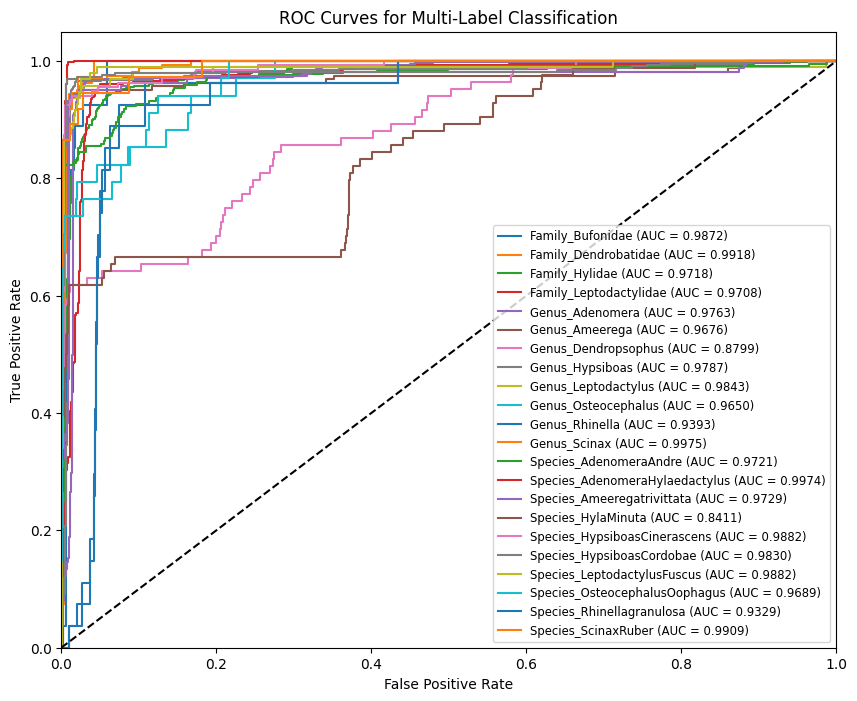

In [125]:
def plot_roc_per_label(y_true, y_scores, label_names):
    plt.figure(figsize=(10, 8))
    for idx, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_true[:, idx], y_scores[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Label Classification')
    plt.legend(loc='lower right', fontsize='small')
    plt.show()

# Per label AUC
auc_per_label = roc_auc_score(y_test_chain, y_scores, average=None)
auc_df = pd.DataFrame({'Label': label_columns, 'AUC': auc_per_label})
print("AUC per label:")
print(auc_df)

# Aggregated AUC scores
auc_micro = roc_auc_score(y_test_chain, y_scores, average='micro')
auc_macro = roc_auc_score(y_test_chain, y_scores, average='macro')
print(f"\nAUC (Micro): {auc_micro:.4f}")
print(f"AUC (Macro): {auc_macro:.4f}")
# Ensure y_scores is of shape (n_samples, n_labels)
plot_roc_per_label(y_test_chain, y_scores, label_columns)


#### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set Monte-Carlo Simulation:

Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose $k\in\{1,2,\cdots,50\}$ automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [137]:
# Feature Scaling
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X)

# 2. Prepare Multi-Label Encoding for Hamming Loss
# Combining all labels into a single list of tuples for multi-label binarization
labels = df[['Family', 'Genus', 'Species']].apply(lambda row: tuple(row), axis=1).tolist()

mlb = MultiLabelBinarizer()
Y_cluster = mlb.fit_transform(labels)

# Convert multi-label to single label for ARI and NMI
# This creates a unique identifier for each unique combination of labels
unique_label_combinations = list(set(labels))
label_to_int = {label: idx for idx, label in enumerate(unique_label_combinations)}
Y_single = np.array([label_to_int[label] for label in labels])

In [144]:
# 3. Determine Optimal k Once Using Silhouette Score
def determine_optimal_k(X, k_min=2, k_max=50):
    best_k = 2
    best_score = -1
    for k in range(k_min, k_max + 1):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        # Silhouette score can be slow for large datasets; consider sampling if necessary
        score = silhouette_score(X, cluster_labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

print("Determining optimal number of clusters (k)...")
optimal_k = determine_optimal_k(X_cluster_scaled, k_min=2, k_max=50)
print(f"Optimal number of clusters determined: k = {optimal_k}")

# 4. Define Clustering and Metric Calculation Function
def clustering_iteration(X, Y, k, iteration):
    # Initialize MiniBatchKMeans with a different random state for each iteration
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=iteration, batch_size=1000, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Compute ARI and NMI
    ari = adjusted_rand_score(Y, cluster_labels)
    nmi = normalized_mutual_info_score(Y, cluster_labels)
    
    return ari, nmi

# 5. Monte-Carlo Simulation with Parallel Processing
def monte_carlo_simulation(X, Y, k, n_iterations=50):
    # Determine the number of CPU cores available
    num_cores = multiprocessing.cpu_count()
    
    # Define the range of iterations
    iterations = range(n_iterations)
    
    # Run simulations in parallel
    results = Parallel(n_jobs=num_cores)(
        delayed(clustering_iteration)(X, Y, k, i) for i in iterations
    )
    
    # Unzip the results
    ari_scores, nmi_scores = zip(*results)
    
    return np.array(ari_scores), np.array(nmi_scores)


Determining optimal number of clusters (k)...
Optimal number of clusters determined: k = 3


In [145]:
print("Starting Monte-Carlo Simulation...")
n_iterations = 50
ari_scores, nmi_scores = monte_carlo_simulation(X_cluster_scaled, Y_single, optimal_k, n_iterations)

# 6. Reporting Average and Standard Deviation
average_ari = np.mean(ari_scores)
std_ari = np.std(ari_scores)
average_nmi = np.mean(nmi_scores)
std_nmi = np.std(nmi_scores)

print(f"\nMonte-Carlo Simulation Results over {n_iterations} iterations:")
print(f"Adjusted Rand Index (ARI): Mean = {average_ari:.4f}, Std = {std_ari:.4f}")
print(f"Normalized Mutual Information (NMI): Mean = {average_nmi:.4f}, Std = {std_nmi:.4f}")


Starting Monte-Carlo Simulation...

Monte-Carlo Simulation Results over 50 iterations:
Adjusted Rand Index (ARI): Mean = 0.5768, Std = 0.1549
Normalized Mutual Information (NMI): Mean = 0.5581, Std = 0.0514


(b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [147]:
# 3. Perform Final K-Means Clustering with Optimal k = 3
optimal_k = 3
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_cluster_scaled)

# 4. Assign Cluster Labels to the DataFrame
df['Cluster'] = cluster_labels

# 5. Function to Determine Majority Labels per Cluster
def get_majority_labels(df, cluster_col='Cluster', label_cols=['Family', 'Genus', 'Species']):
    majority_labels = {}
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        majority_labels[cluster] = {}
        for label in label_cols:
            majority_class = cluster_data[label].mode()[0]
            majority_count = cluster_data[label].value_counts().iloc[0]
            total = cluster_data[label].count()
            majority_percentage = (majority_count / total) * 100
            majority_labels[cluster][label] = {
                'Majority_Class': majority_class,
                'Count': majority_count,
                'Percentage': majority_percentage
            }
    return majority_labels

# 6. Get Majority Labels per Cluster
majority_labels = get_majority_labels(df, cluster_col='Cluster', label_cols=['Family', 'Genus', 'Species'])

# 7. Display the Results
for cluster, labels in majority_labels.items():
    print(f"\nCluster {cluster}:")
    for label, info in labels.items():
        print(f"  {label}: {info['Majority_Class']} (Count: {info['Count']}, {info['Percentage']:.2f}%)")



Cluster 0:
  Family: Hylidae (Count: 594, 94.89%)
  Genus: Hypsiboas (Count: 533, 85.14%)
  Species: HypsiboasCinerascens (Count: 454, 72.52%)

Cluster 1:
  Family: Leptodactylidae (Count: 3463, 96.89%)
  Genus: Adenomera (Count: 3463, 96.89%)
  Species: AdenomeraHylaedactylus (Count: 3463, 96.89%)

Cluster 2:
  Family: Hylidae (Count: 1460, 48.75%)
  Genus: Hypsiboas (Count: 1043, 34.82%)
  Species: HypsiboasCordobae (Count: 1025, 34.22%)


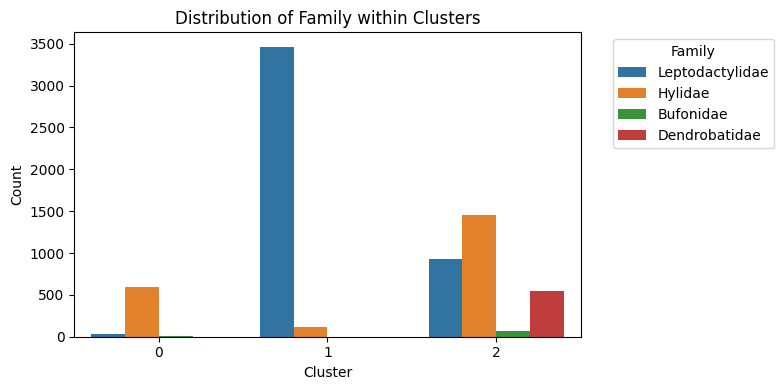

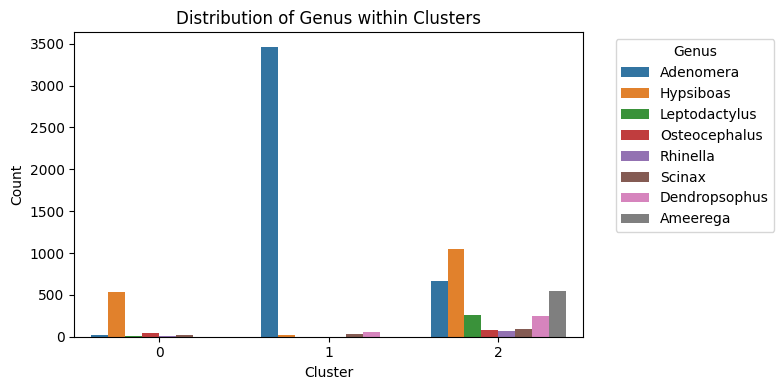

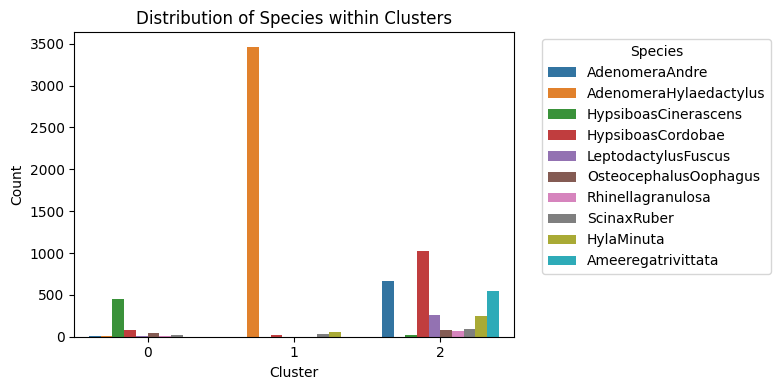

In [172]:
# Function to plot distribution of a label within clusters
def plot_label_distribution(df, cluster_col='Cluster', label_col='Family'):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=cluster_col, hue=label_col)
    plt.title(f'Distribution of {label_col} within Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=label_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example: Plotting Family distribution within clusters
plot_label_distribution(df, cluster_col='Cluster', label_col='Family')

# Similarly, you can plot for Genus and Species
plot_label_distribution(df, cluster_col='Cluster', label_col='Genus')
plot_label_distribution(df, cluster_col='Cluster', label_col='Species')

(c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss (Research what these scores are. For example, see the paper A Literature Survey on Algorithms for Multi-label Learning, by Mohammad Sorower) between the true labels and the labels assigned by clusters.

**Answer:**

**Hamming Distance**: Measures the number of label mismatches between the true labels and the predicted labels. In multi-label classification, it's the number of labels that are different.

**Hamming Loss**: Represents the fraction of labels that are incorrectly predicted. It's the average of the Hamming Distance over all instances normalized by the total number of labels.

**Hamming Score**: Often interpreted as the subset accuracy or the exact match ratio. It calculates the proportion of instances where all labels are correctly predicted.

Our objective is to compare the true labels with the predicted labels derived from cluster assignments.

In [168]:
def calculate_hamming_metrics(df, majority_labels, cluster_col='Cluster', label_cols=['Family', 'Genus', 'Species']):
    hamming_distance = 0
    hamming_score = 0
    total_instances = len(df)
    total_labels = len(label_cols)
    
    for _, row in df.iterrows():
        cluster = row[cluster_col]
        true_labels = row[label_cols]
        majority_triplet = majority_labels[cluster]
        
        # Calculate mismatches and matches
        mismatches = sum(1 for label in label_cols if true_labels[label] != majority_triplet[label]['Majority_Class'])
        matches = total_labels - mismatches
        
        # Update hamming metrics
        hamming_distance += mismatches
        hamming_score += matches / total_labels
    
    average_hamming_distance = hamming_distance / total_instances
    average_hamming_score = hamming_score / total_instances
    hamming_loss = 1 - average_hamming_score
    
    return average_hamming_distance, average_hamming_score, hamming_loss

In [170]:
# Calculate Hamming metrics
average_hamming_distance, average_hamming_score, hamming_loss = calculate_hamming_metrics(df, majority_labels)

# Print the results
print(f"Average Hamming Distance: {average_hamming_distance:.4f}")
print(f"Hamming Score: {average_hamming_score:.4f}")
print(f"Hamming Loss: {hamming_loss:.4f}")

Average Hamming Distance: 0.8460
Hamming Score: 0.7180
Hamming Loss: 0.2820


#### 3. Dendrogram with Dissimlarity Matrix

Suppose that we have four observations, for which we compute a dissimilarity matrix, given by 
$$\begin{bmatrix} 0.0 & 0.3 & 0.4 & 0.7 \\
                 0.3 & 0.0 & 0.5 & 0.8 \\
                 0.4 & 0.5 & 0.0 & 0.45 \\
                 0.7 & 0.8 & 0.45 & 0.0 \\
\end{bmatrix}$$
For instance, the dissimilarity between the first and second obser- vations is 0.3, and the dissimilarity between the second and fourth observations is 0.8.

(a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

**Answer:**

Initial Observations: Start with each observation as its own cluster: {1}, {2}, {3}, {4}.

First Merge:
- Find the smallest dissimilarity that is not zero (i.e., not the diagonal).
- We see that 0.3, the dissimilarity between observation 1 and observation 2, is the smallest.
- Merge observations 1 and 2 to form a new cluster: {1, 2}.

Second Merge:
- Recalculate the dissimilarity between clusters using complete linkage. The dissimilarity between clusters {1, 2} and any other observation is the maximum dissimilarity between observations in these two clusters.
- Compute {1, 2} vs {3}: max(0.4, 0.5) = 0.5
- Compute {1, 2} vs {4}: max(0.7, 0.8) = 0.8
- The smallest dissimilarity is between {3} and {4}, at 0.45.
- Merge observations 3 and 4 to form a new cluster: {3, 4}.

Final Merge:
- Now compare the two clusters {1, 2} and {3, 4}.
- The dissimilarity is the maximum of the dissimilarity between all points in {1, 2} and {3, 4}: max(0.5, 0.8, 0.45, 0.7) = 0.8.
- Merge the two clusters {1, 2} and {3, 4}.

With the clusters determined, you can draw the dendrogram as follows:
- Place leaf nodes for observations 1, 2, 3, and 4 at the bottom.
- Draw lines to the merging steps:
- - Join nodes 1 and 2 at height 0.3.
- - Join nodes 3 and 4 at height 0.45.
- - Join clusters {1, 2} and {3, 4} at height 0.8.

The dendrogram will have two fusions at heights 0.3 and 0.45, and the final fusion at height 0.8. Note that the height represents the dissimilarity at which these clusters are merged.

(b) Repeat (a), this time using single linkage clustering.

**Answer:**

Initial Observations: Start with each observation as its own cluster: {1}, {2}, {3}, {4}.

First Merge:
- Find the smallest non-zero dissimilarity. The smallest value is 0.3 between observations 1 and 2.
- Merge observations 1 and 2 into a new cluster: {1, 2}.

Second Merge:
- Calculate the dissimilarity between cluster {1, 2} and the other observations using single linkage (minimum distance method):
- - {1, 2} vs {3}: min(0.4, 0.5) = 0.4
- - {1, 2} vs {4}: min(0.7, 0.8) = 0.7
- The smallest distance is between {1, 2} and {3}, at 0.4.
- Merge {1, 2} with {3} to form a new cluster: {1, 2, 3}.

Final Merge:
- Now, only clusters {1, 2, 3} and {4} remain: {1, 2, 3} vs {4}: min(0.7, 0.8, 0.45) = 0.45
- Merge {1, 2, 3} with {4}.

The important heights for the dendrogram are:
- 0.3 for the first merge ({1} with {2}),
- 0.4 for the second merge ({1, 2} with {3}),
- 0.45 for the final merge ({1, 2, 3} with {4}).

(c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?

**Answer:**

For complete linkage (from part (a)), recall the merge sequence:
1. {1} with {2} at height 0.3.
2. {3} with {4} at height 0.45.
3. Final merge of {1, 2} with {3, 4} at height 0.8.

If we cut the dendrogram to obtain two clusters, we cut before the height of 0.8. Therefore, the clusters formed are:
- Cluster 1: {1, 2}
- Cluster 2: {3, 4}

(d) Suppose that we cut the dendrogram obtained in (b) such that two clusters result. Which observations are in each cluster?

**Answer:**

For single linkage (from part (b)), remember the merge sequence:
1. {1} with {2} at height 0.3.
2. {1, 2} with {3} at height 0.4.
3. Final merge of {1, 2, 3} with {4} at height 0.45.

For two clusters, cut before the final height of 0.45:
- Cluster 1: {1, 2, 3}
- Cluster 2: {4}

(e) It is mentioned in this chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same.

**Answer:**

**Original Merge Sequence (Complete Linkage)**
1. Merge observations 1 and 2 at height 0.3.
2. Merge observations 3 and 4 at height 0.45.
3. Merge clusters {1, 2} and {3, 4} at height 0.8.

**Repositioned Dendrogram**

We can swap the positions of any clusters at each level of the merge. An equivalent but reordered dendrogram might be:
1. Start with moving the leaf:
- Swap observations 3 and 4 so that the single merge appears as: {4} and {3} at height 0.45.
2. Change the cluster order:
- Start with cluster {4, 3} on the left and merge it with {2, 1}.

**Resulting Dendrogram**

Here's how this might look as a sketch:

```
  Height
    |
0.8 |      ----- {4, 3, 2, 1}  
    |
0.45|    -----
    |   |     |
    |   | {4} {3}
0.3 |   |  
    | --- 
    | |   |
    | {2} {1}
    -------------------------
           Observations
```

**Key Points of above Dendrogram**
- Observations 3 and 4 are swapped, changing their order in the dendrogram.
- The final cluster pairing is reversed to merge {4, 3} with {2, 1}.
- The clusters are still merged at the correct heights (0.3, 0.45, 0.8).
- The heights at which merges occur remain unchanged, as do the clusters involved in each merge, preserving the original meaning and information of the dendrogram.
- By arranging the leaves differently, we maintain the clustering information while presenting an alternate visual order.